# Farnebäck Optical Flow Algorithm Tutorial

The notebook will bring you going through the key processes in Farnebäck optical flow algorithm OpenCV implementation. I will try to explain them step by step and introduce the underlying mathematics simultaneously.
In short, Farneback algorithm consists two major steps: first, polynomial expansion; second, displacement estimation. Here we grab two images from Middlebury dataset as our input and we do not consider aperture problem at this stage.

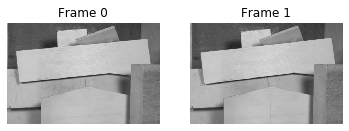

In [2]:
import math

import cv2
import numpy as np
from matplotlib import pyplot as plt

image0 = cv2.imread("assets/Wooden/frame10.png", cv2.IMREAD_GRAYSCALE)
image1 = cv2.imread("assets/Wooden/frame11.png", cv2.IMREAD_GRAYSCALE)
images = [image0, image1]
show0 = cv2.cvtColor(images[0], cv2.COLOR_GRAY2RGB)
show1 = cv2.cvtColor(images[1], cv2.COLOR_GRAY2RGB)

fig = plt.figure()
showFig = fig.add_subplot(1, 2, 1)
plt.imshow(show0)
showFig.set_title("Frame 0")
showFig.axis('off')
showFig = fig.add_subplot(1, 2, 2)
plt.imshow(show1)
showFig.set_title("Frame 1")
showFig.axis('off')
plt.show()

## Polynomial Expansion
Polynomial expansion approximates the neighborhood of each pixel for each frame as a quadratic polynomial. The polynomials are the basic representation of features in the algirithm. The basic form of quadratic polynomial is:
$$f(\mathbf{x}) \sim \mathbf{x}^T \mathbf{A x} + \mathbf{b}^T \mathbf{x} + c.$$
In the algorithm, there are two parameters: size of the pixel neighborhood and standard deviation of the Gaussian used to smooth derivatives used as a basis for the polynomial expansion, we set them 5 and 1.1 respectively.

### Prepare Gaussian
Calculate the inverse of matrix G
$$\mathbf{G = B^*W_a W_c B}.$$

In [ ]:
def PrepareGausian(polyn, sigma, g, xg, xxg):
    s = 0
    for x in range(-polyn, polyn+1):
        g[x] = math.exp(-x*x/(2*sigma*sigma))
        s += g[x]

    s = 1.0/s
    for x in range(-polyn, polyn+1):
        g[x] = g[x]*s
        xg[x] = x*g[x]
        xxg[x] = x*x*g[x]
    
    G = np.zeros((6, 6))
    for y in range(-polyn, polyn+1):
        for x in range(-polyn, polyn+1):
            G[0, 0] += g[y]*g[x]
            G[1, 1] += g[y]*g[x]*x*x m
            G[3, 3] += g[y]*g[x]*x*x*x*x
            G[5, 5] += g[y]*g[x]*x*x*y*y
            
    G[2, 2] = G[0, 3] = G[0, 4] = G[3, 0] = G[4, 0] = G[1, 1]
    G[4, 4] = G[3, 3]
    G[3, 4] = G[4, 3] = G[5, 5]
    
    # invG:
    # [ x        e  e    ]
    # [    y             ]
    # [       y          ]
    # [ e        z       ]
    # [ e           z    ]
    # [                u ]

    invG = np.linalg.inv(G) # use Cholesky if possible
    # ig11, ig03, ig33, ig55
    return (invG(1, 1), invG(0, 3), invG(3, 3), invG(5, 5))


### Polynomial Expansion
Construct correlation kernels and convolve.

In [6]:
polyN = 5
polySigma = 1.1

for img in images:
    width = img.shape[1]
    height = img.shape[0]
    kbuf = np.empty(polyN*6 + 3, dtype=np.float32)
    rowbuf = np.empty((width + polyN*2)*3, dtype=np.float32)
    index_g = polyN
    index_xg = index_g + polyN*2 +1
    index_xxg = index_xg + polyN*2 + 1
    index_row = polyN*3
    ig = PrepareGaussian(n, sigma, g, xg, xxg)
    ig11 = ig[0]
    ig03 = ig[1]
    ig33 = ig[2]
    ig55 = ig[3]
    
    dst = np.empty((height, width, 5), dtype=np.float32)
    for y in range(0, height):
        g0 = g[0]
        float *srow0 = src.ptr<float>(y), *srow1 = 0
        float *drow = dst.ptr<float>(y)

        # vertical part of convolution
        for x in range(0, width):
            row[x*3] = srow0[x]*g0
            row[x*3+1] = row[x*3+2] = 0.0

        for k in range(1, n+1):
            g0 = g[k]
            g1 = xg[k]
            g2 = xxg[k]
            srow0 = src.ptr<float>(max(y-k, 0))
            srow1 = src.ptr<float>(min(y+k, height-1))

            for x in range(0, width):
                float p = srow0[x] + srow1[x]
                float t0 = row[x*3] + g0*p
                float t1 = row[x*3+1] + g1*(srow1[x] - srow0[x])
                float t2 = row[x*3+2] + g2*p

                row[x*3] = t0
                row[x*3+1] = t1
                row[x*3+2] = t2

        # horizontal part of convolution
        for x in range(0, n*3):
            row[-1-x] = row[2-x]
            row[width*3+x] = row[width*3+x-3]

        for x in range(0, width):
            g0 = g[0]
            # r1 ~ 1, r2 ~ x, r3 ~ y, r4 ~ x^2, r5 ~ y^2, r6 ~ xy
            b1 = row[x*3]*g0
            b2 = 0
            b3 = row[x*3+1]*g0
            b4 = 0
            b5 = row[x*3+2]*g0
            b6 = 0

            for k in range(1, n+1):
                double tg = row[(x+k)*3] + row[(x-k)*3]
                g0 = g[k]
                b1 += tg*g0
                b4 += tg*xxg[k]
                b2 += (row[(x+k)*3] - row[(x-k)*3])*xg[k]
                b3 += (row[(x+k)*3+1] + row[(x-k)*3+1])*g0
                b6 += (row[(x+k)*3+1] - row[(x-k)*3+1])*xg[k]
                b5 += (row[(x+k)*3+2] + row[(x-k)*3+2])*g0

            # do not store r1
            drow[x*5+1] = b2*ig11
            drow[x*5] = b3*ig11
            drow[x*5+3] = b1*ig03 + b4*ig33
            drow[x*5+2] = b1*ig03 + b5*ig33
            drow[x*5+4] = b6*ig55

    row -= n*3

In [ ]:
sigma = (1.0/scale-1)*0.5;
smooth_sz = cvRound(sigma*5)|1;
smooth_sz = std::max(smooth_sz, 3);
for image in images:
    image = cv2.GaussianBlur(image)


### Normalized convolution

## Displacement Estimation


In [ ]:
def UpdateMatrices():
    BORDER = 5
    border = [0.14, 0.14, 0.4472, 0.4472, 0.4472]
    width = flow.shape[1]
    height = flow.shape[0]
    y0 = 0
    y1 = height
    # pixel number per line
    step1 = width
    #step1 = _R1.step/sizeof(R1[0])
    matM = np.empty((height, width, 5), dtype=np.float32)

    for y in range(y0, y1):
        index_flow = y
        index_R0 = y
        index_M = y
        for x in range(0, width):
            dx = flow[x*2]
            dy = flow[x*2+1]
            fx = x + dx
            fy = y + dy

            x1 = math.floor(fx)
            y1 = math.floor(fy)
            index_ptr = R1 + y1*step1 + x1*5

            fx -= x1
            fy -= y1

            if abs(x1) < abs(width-1) and abs(y1) < abs(height-1):
                a00 = (1.0-fx)*(1.0-fy)
                a01 = fx*(1.0-fy)
                a10 = (1.0-fx)*fy
                a11 = fx*fy
                r2 = a00*ptr[0] + a01*ptr[5] + a10*ptr[step1] + a11*ptr[step1+5]
                r3 = a00*ptr[1] + a01*ptr[6] + a10*ptr[step1+1] + a11*ptr[step1+6]
                r4 = a00*ptr[2] + a01*ptr[7] + a10*ptr[step1+2] + a11*ptr[step1+7]
                r5 = a00*ptr[3] + a01*ptr[8] + a10*ptr[step1+3] + a11*ptr[step1+8]
                r6 = a00*ptr[4] + a01*ptr[9] + a10*ptr[step1+4] + a11*ptr[step1+9]

                r4 = (R0[x*5+2] + r4)*0.5
                r5 = (R0[x*5+3] + r5)*0.5
                r6 = (R0[x*5+4] + r6)*0.25
            else:
                r2 = r3 = 0.0
                r4 = R0[x*5+2]
                r5 = R0[x*5+3]
                r6 = R0[x*5+4]*0.5
        
            r2 = (R0[x*5] - r2)*0.5
            r3 = (R0[x*5+1] - r3)*0.5

            r2 += r4*dy + r6*dx
            r3 += r6*dy + r5*dx

            if abs(x - BORDER) >= abs(width - BORDER*2) or abs(y - BORDER) >= abs(height - BORDER*2):
                scale = (border[x] if x < BORDER else 1.0)*(border[width - x - 1] if x >= width-BORDER else 1.0)*(border[y] if y < BORDER else 1.0)*(border[height - y - 1] if y >= height - BORDER else 1.0)
                r2 *= scale
                r3 *= scale
                r4 *= scale
                r5 *= scale
                r6 *= scale

            M[x*5]   = r4*r4 + r6*r6 # G(1,1)
            M[x*5+1] = (r4 + r5)*r6  # G(1,2)=G(2,1)
            M[x*5+2] = r5*r5 + r6*r6 # G(2,2)
            M[x*5+3] = r4*r2 + r6*r3 # h(1)
            M[x*5+4] = r6*r2 + r5*r3 # h(2)


In [ ]:
def UpdateFlow_Blur(_R0, _R1, _flow, matM, block_size):
    width = flow.shape[1]
    height = flow.shape[0]
    m = block_size//2
    y0 = 0, y1
    int min_update_stripe = std::max((1 << 10)/width, block_size)
    double scale = 1.0/(block_size*block_size)

    AutoBuffer<double> _vsum((width+m*2+2)*5)
    index_vsum = (m+1)*5

    # init vsum
    float* srow0 = matM.ptr<float>()
    for x in range(0, width*5):
        vsum[x] = srow0[x]*(m+2)

    for y in range(1, m):
        srow0 = matM.ptr<float>(std::min(y,height-1))
        for x in range(0, width*5):
            vsum[x] += srow0[x]

    # compute blur(G)*flow=blur(h)
    for y in range(0, height):
        float* flow = _flow.ptr<float>(y)

        srow0 = matM.ptr<float>(std::max(y-m-1,0))
        const float* srow1 = matM.ptr<float>(std::min(y+m,height-1))

        # vertical blur
        for x in range(0, width*5):
            vsum[x] += srow1[x] - srow0[x]

        # update borders
        for x in range(0, (m+1)*5):
            vsum[-1-x] = vsum[4-x]
            vsum[width*5+x] = vsum[width*5+x-5]

        # init g** and h*
        g11 = vsum[0]*(m+2)
        g12 = vsum[1]*(m+2)
        g22 = vsum[2]*(m+2)
        h1 = vsum[3]*(m+2)
        h2 = vsum[4]*(m+2)

        for x in range(1, m):
            g11 += vsum[x*5]
            g12 += vsum[x*5+1]
            g22 += vsum[x*5+2]
            h1 += vsum[x*5+3]
            h2 += vsum[x*5+4]

        # horizontal blur
        for x in range(0, width):
            g11 += vsum[(x+m)*5] - vsum[(x-m)*5 - 5]
            g12 += vsum[(x+m)*5 + 1] - vsum[(x-m)*5 - 4]
            g22 += vsum[(x+m)*5 + 2] - vsum[(x-m)*5 - 3]
            h1 += vsum[(x+m)*5 + 3] - vsum[(x-m)*5 - 2]
            h2 += vsum[(x+m)*5 + 4] - vsum[(x-m)*5 - 1]

            g11_ = g11*scale
            g12_ = g12*scale
            g22_ = g22*scale
            h1_ = h1*scale
            h2_ = h2*scale

            idet = 1.0/(g11_*g22_ - g12_*g12_+1e-3)

            flow[x*2] = (g11_*h2_-g12_*h1_)*idet
            flow[x*2+1] = (g22_*h1_-g12_*h2_)*idet
        
        if y == height-1:
            y1 = height
        else:
            y1 = y - block_size


### Multi-scale displacement estimation

## Remark: Gaussian Pyramid